In [1]:
!pip install keras

    100% |████████████████████████████████| 327kB 2.2MB/s 


In [2]:
import numpy as np

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.layers import Activation, Input

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')


Using TensorFlow backend.


### Loading data (Olivetti faces)

In [3]:
data_obj = fetch_olivetti_faces()

X = data_obj['data']
X = 1.0 * (X > 0.5)

y = data_obj['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=0)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /content/scikit_learn_data


### RBM definitions

RBMs are undirected graphical models with the following structure ($h_i, v_j$ are binary):

<p align="center"><img src="http://40.media.tumblr.com/5e4a23b85f61e2aaeeb1188c2e35536a/tumblr_inline_npz2ev1m5Y1rnd3q0_540.png" /></p>

The joint probability is given by:
$$E(v, h) = vWh$$

$$P(v, h) = \frac{e^{-E(v, h)}}{\sum_{u, g}e^{-E(u, g)}}$$

That means that $$P(h|v) = \prod_{i}P(h_i|v)$$, and consequently from the definition $$P(h_i = 1|v) = \frac{1}{1 + exp(vW_{:, i})}$$

In [0]:
def probabilities_from_other(W, other):
  """
  Get probabilities from hidden given visible or the other way around
  """
  energy = K.dot(other, W)
  return Activation('sigmoid')(energy)


def sample_bernoulli(probas):
  uniform_samples = K.random_uniform(shape=K.shape(probas))
  bernoulli_samples = K.greater(
    1 - probas,
    uniform_samples
  )
  return K.cast(bernoulli_samples, K.floatx())


def sample_from_other(W, other):
  """
  Sample hidden given visible or the other way around
  """
  proba = probabilities_from_other(W, other)
  return sample_bernoulli(proba)



def configuration_goodness_gradient(visible, hidden):
  """
  Gradient of (negative) energy 
  """
  n_samples_norm = K.cast(1 / K.shape(visible)[0], K.floatx())
  return - n_samples_norm * K.dot(
      K.transpose(visible),
      hidden,
  )


def cd1_variables(W, visible):
  hidden0 = K.identity(sample_from_other(W, visible), name='hidden0')
  
  visible_proba1 = probabilities_from_other(K.transpose(W), hidden0)
  visible1 = K.identity(sample_bernoulli(visible_proba1), name='visible1')
  
  hidden1 = K.identity(sample_from_other(W, visible1), name='hidden1')

  return hidden0, visible1, hidden1


def cd1(W, visible):
  hidden0, visible1, hidden1 = cd1_variables(W, visible)
  goodness_gradient0 = configuration_goodness_gradient(visible, hidden0)
  goodness_gradient1 = configuration_goodness_gradient(visible1, hidden1)
  
  return - goodness_gradient0 + goodness_gradient1

### RBM setup

In [0]:
n_visible = X_train.shape[1]
n_hidden = 1000

W_in = K.variable(np.random.randn(n_visible, n_hidden) / 100)
visible_shape = (n_visible,)
visible_in = Input(shape=visible_shape)

cd = cd1(W_in, visible_in)

In [0]:
lr = 0.02

train_op = K.function(
    inputs=[visible_in],
    outputs=[cd],
    updates=[K.update(W_in, W_in - lr *cd)])

In [8]:
print(K.eval(W_in))

[[-8.5334172e-03  1.3319059e-02  6.6813435e-03 ... -8.8554844e-03
  -2.2853990e-03  6.7339796e-03]
 [-1.1239128e-02  2.0993915e-03 -1.0803039e-02 ... -1.3950084e-03
  -6.0649561e-03 -5.5662766e-03]
 [ 1.5914880e-03  1.0836151e-02 -2.1256831e-02 ... -2.2135966e-03
  -1.4866214e-02 -6.8296548e-03]
 ...
 [-3.0861363e-02 -8.9680078e-03  1.3327737e-02 ...  7.9539679e-03
   6.4351503e-03 -5.7511283e-03]
 [-1.7461579e-03  2.4845542e-03 -8.9698944e-05 ... -2.6246998e-03
  -4.2409580e-03  3.4833674e-03]
 [-8.8593848e-03 -2.6292037e-03  1.1961174e-03 ... -1.0144725e-02
  -1.8348671e-02  1.9815441e-03]]


In [9]:
%%time

minibatch_size = 64
n_epochs = 1000

for __ in range(n_epochs):
  for i in range(X_train.shape[0] // minibatch_size):
    minibatch = X_train[i * minibatch_size:(i+1) * minibatch_size]
    train_op([minibatch])

CPU times: user 21.9 s, sys: 9.24 s, total: 31.1 s
Wall time: 34.5 s


In [10]:
print(K.eval(W_in))

[[ 1.23341456e-01 -4.18094452e-03  1.09806299e-01 ...  4.77069803e-02
  -1.91604123e-02 -1.07660461e-02]
 [ 1.18760780e-01 -1.35255819e-02 -3.89279909e-02 ...  3.82924676e-02
  -2.23149117e-02 -2.15037167e-02]
 [ 2.99092710e-01 -5.10133989e-03 -9.21942517e-02 ...  8.49738419e-02
  -3.08037326e-02 -2.24546324e-02]
 ...
 [ 2.82577574e-01 -1.89680085e-02  7.73902014e-02 ... -3.76710147e-02
  -4.18984657e-03 -1.60636157e-02]
 [ 3.54818821e-01 -3.27940856e-04  5.17852679e-02 ...  5.50027005e-03
  -5.49095636e-03  1.29587529e-03]
 [ 2.75517583e-01 -4.19171900e-03  7.55710676e-02 ...  2.95427591e-02
  -1.92860737e-02  4.19049815e-04]]


In [0]:
sample_hidden_from_visible = K.function(
  inputs=[visible_in],
  outputs=[sample_from_other(W_in, visible_in)]
)

hidden_input = Input(shape=(n_hidden,))
sample_visible_from_hidden = K.function(
  inputs=[hidden_input],
  outputs=[sample_from_other(K.transpose(W_in), hidden_input)]
)

In [0]:
[sampled_hidden] = sample_hidden_from_visible([X_test])
[sampled_visible] = sample_visible_from_hidden([sampled_hidden])

### Show reconstructed face

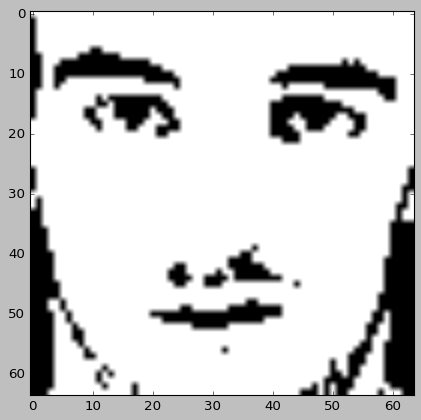

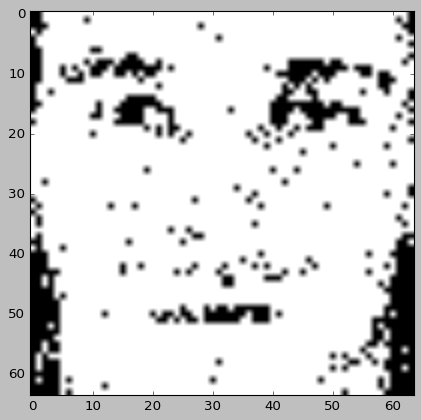

In [13]:
i = 1

plt.imshow(X_test[i].reshape(64, 64), cmap='gray')
plt.title('original')
plt.show()
plt.imshow(sampled_visible[i].reshape(64, 64), cmap='gray')
plt.title('reconstructed')
plt.show()